## **I. Introduction**

Nama : `Banyu Nurmanjaya`

### **I.I. Background**



``Jakarta, sebagai metropolitan, seringkali menghadapi masalah kualitas udara yang buruk.`` Tingkat polusi udara yang tinggi, terutama partikel halus seperti PM2.5, memiliki dampak negatif yang signifikan terhadap kesehatan masyarakat. ``Paparan jangka panjang terhadap PM2.5 dapat menyebabkan berbagai masalah pernapasan, kardiovaskular, dan bahkan meningkatkan risiko penyakit kronis lainnya.``

### **I.II. Object** 

``Membangun dan mengevaluasi model regresi linear yang mampu memprediksi konsentrasi PM2.5 (variabel target) berdasarkan konsentrasi PM10 (variabel prediktor)`` dengan memanfaatkan dataset kualitas udara DKI Jakarta (2010-2023) yang berasal dari 5 stasiun pemantauan.

## **II. Dataset**

**Judul :** Air Quality Index in Jakarta

**Deskripsi :** Dataset ini berisi Indeks Kualitas Udara (AQI) atau Indeks Standar Pencemaran Udara (ISPU) yang diukur dari 5 stasiun pemantauan kualitas udara (SPKU) di DKI Jakarta pada tahun 2010-2023.

**Sumber :** https://www.kaggle.com/datasets/senadu34/air-quality-index-in-jakarta-2010-2021

![Jakarta](jakarta.jpeg)

| Kolom | Deskripsi |
|---|---|
| tanggal | Tanggal ketika pengukuran AQI dicatat |
| stasiun | Nama atau pengenalan stasiun pemantauan tempat pengukuran dilakukan |
| pm10 | Konsentrasi materi partikulat dengan diameter 10 mikrometer atau kurang (PM10), diukur dalam mikrogram per meter kubik (µg/m³) |
| pm25 | Konsentrasi materi partikulat dengan diameter 2,5 mikrometer atau kurang (PM2.5), diukur dalam mikrogram per meter kubik (µg/m³) |
| so2 | Konsentrasi sulfur dioksida (SO2), diukur dalam bagian per juta (ppm) |
| co | Konsentrasi karbon monoksida (CO), diukur dalam bagian per juta (ppm) |
| o3 | Konsentrasi ozon (O3), diukur dalam bagian per juta (ppm) |
| no2 | konsentrasi nitrogen dioksida (NO2), diukur dalam bagian per juta (ppm) |
| max | Nilai maksimum yang tercatat di antara polutan untuk tanggal dan stasiun tertentu. Nilai ini menunjukkan konsentrasi tertinggi di antara PM10, SO2, CO, O3, dan NO2 |
| critical | Polutan yang memiliki konsentrasi tertinggi untuk tanggal dan stasiun tersebut |
| category | Kategori kualitas udara berdasarkan nilai maks. Kategori ini menggambarkan tingkat kualitas udara |

## **III. Import Library**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

from feature_engine.outliers import Winsorizer
from scipy.stats import f_oneway
from scipy.stats import spearmanr

import pickle

In [7]:
import sklearn
print(sklearn.__version__)

1.2.2


## **IV. Data Loading**

In [8]:
try:
    df = pd.read_csv("ispu_dki_all.csv")
except FileNotFoundError:
    print("Error: File ispu_dki_all.csv not found.")
    exit()

In [9]:
new_colums = {
    'tanggal': 'date',
    'stasiun': 'station',
    'categori': 'category'
}

df = df.rename(columns=new_colums)

In [10]:
df.head(10)

,date,station,pm10,pm25,so2,co,o3,no2,max,critical,category
0,2010-01-01,DKI1 (Bunderan HI),60.0,NaN,4.0,73.0,27.0,14.0,73.0,CO,SEDANG
1,2010-01-02,DKI1 (Bunderan HI),32.0,NaN,2.0,16.0,33.0,9.0,33.0,O3,BAIK
2,2010-01-03,DKI1 (Bunderan HI),27.0,NaN,2.0,19.0,20.0,9.0,27.0,PM10,BAIK
3,2010-01-04,DKI1 (Bunderan HI),22.0,NaN,2.0,16.0,15.0,6.0,22.0,PM10,BAIK
4,2010-01-05,DKI1 (Bunderan HI),25.0,NaN,2.0,17.0,15.0,8.0,25.0,PM10,BAIK
5,2010-01-06,DKI1 (Bunderan HI),30.0,NaN,3.0,22.0,19.0,11.0,30.0,PM10,BAIK
6,2010-01-07,DKI1 (Bunderan HI),41.0,NaN,4.0,24.0,27.0,13.0,41.0,PM10,BAIK
7,2010-01-08,DKI1 (Bunderan HI),64.0,NaN,8.0,51.0,19.0,15.0,64.0,PM10,SEDANG
8,2010-01-09,DKI1 (Bunderan HI),55.0,NaN,5.0,39.0,23.0,16.0,55.0,PM10,SEDANG
9,2010-01-10,DKI1 (Bunderan HI),34.0,NaN,5.0,23.0,26.0,12.0,34.0,PM10,BAIK


In [11]:
df.tail(10)

,date,station,pm10,pm25,so2,co,o3,no2,max,critical,category
4616,2023-11-21,DKI4 (Lubang Buaya),59.0,89.0,30.0,18.0,19.0,18.0,89.0,PM25,SEDANG
4617,2023-11-22,DKI4 (Lubang Buaya),58.0,74.0,30.0,19.0,24.0,19.0,74.0,PM25,SEDANG
4618,2023-11-23,DKI1 (Bunderan HI),56.0,93.0,44.0,11.0,38.0,30.0,93.0,PM25,SEDANG
4619,2023-11-24,DKI5 (Kebon Jeruk),71.0,112.0,36.0,23.0,54.0,26.0,112.0,PM25,TIDAK SEHAT
4620,2023-11-25,DKI5 (Kebon Jeruk),63.0,101.0,33.0,20.0,49.0,22.0,101.0,PM25,TIDAK SEHAT
4621,2023-11-26,DKI1 (Bunderan HI),55.0,75.0,43.0,15.0,15.0,25.0,75.0,PM25,SEDANG
4622,2023-11-27,DKI3 (Jagakarsa),54.0,77.0,56.0,13.0,27.0,16.0,77.0,PM25,SEDANG
4623,2023-11-28,DKI1 (Bunderan HI),62.0,96.0,45.0,15.0,29.0,34.0,96.0,PM25,SEDANG
4624,2023-11-29,DKI4 (Lubang Buaya),71.0,105.0,30.0,19.0,22.0,14.0,105.0,PM25,TIDAK SEHAT
4625,2023-11-30,DKI1 (Bunderan HI),38.0,67.0,43.0,12.0,34.0,34.0,67.0,PM25,SEDANG


In [12]:
print(df['pm25'].describe())

count    723.000000
mean      94.374827
std       27.427553
min       23.000000
25%       76.000000
50%       94.000000
75%      111.000000
max      287.000000
Name: pm25, dtype: float64


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4626 entries, 0 to 4625
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      4626 non-null   object 
 1   station   4626 non-null   object 
 2   pm10      4466 non-null   float64
 3   pm25      723 non-null    float64
 4   so2       4607 non-null   float64
 5   co        4618 non-null   float64
 6   o3        4621 non-null   float64
 7   no2       4618 non-null   float64
 8   max       4626 non-null   float64
 9   critical  4625 non-null   object 
 10  category  4626 non-null   object 
dtypes: float64(7), object(4)
memory usage: 397.7+ KB


**Informasi :**

- Dataset memiliki `4626 baris` dan `11 kolom`
- Selain kolom date, station, max, categori `memiliki nilai yang hilang`
- Kolom pm10, pm25, so2, co, o3, no2, max adalah `bertipe data float`
- Kolom date, station, critical, categori adalah `bertipe data object`
- Kolom date `perlu di konversi ke tipe data date`


In [14]:
df['date'] = pd.to_datetime(df['date'])

print(df.dtypes)

date        datetime64[ns]
station             object
pm10               float64
pm25               float64
so2                float64
co                 float64
o3                 float64
no2                float64
max                float64
critical            object
category            object
dtype: object


## **V. Exploratory Data Analyst (EDA)**

In [15]:
data_viz = df.copy()

In [16]:
data_viz.head(5)

,date,station,pm10,pm25,so2,co,o3,no2,max,critical,category
0,2010-01-01,DKI1 (Bunderan HI),60.0,NaN,4.0,73.0,27.0,14.0,73.0,CO,SEDANG
1,2010-01-02,DKI1 (Bunderan HI),32.0,NaN,2.0,16.0,33.0,9.0,33.0,O3,BAIK
2,2010-01-03,DKI1 (Bunderan HI),27.0,NaN,2.0,19.0,20.0,9.0,27.0,PM10,BAIK
3,2010-01-04,DKI1 (Bunderan HI),22.0,NaN,2.0,16.0,15.0,6.0,22.0,PM10,BAIK
4,2010-01-05,DKI1 (Bunderan HI),25.0,NaN,2.0,17.0,15.0,8.0,25.0,PM10,BAIK


### **V.I. Time Series Plot Tingkat Polutan (PM10 dan PM2.5)**

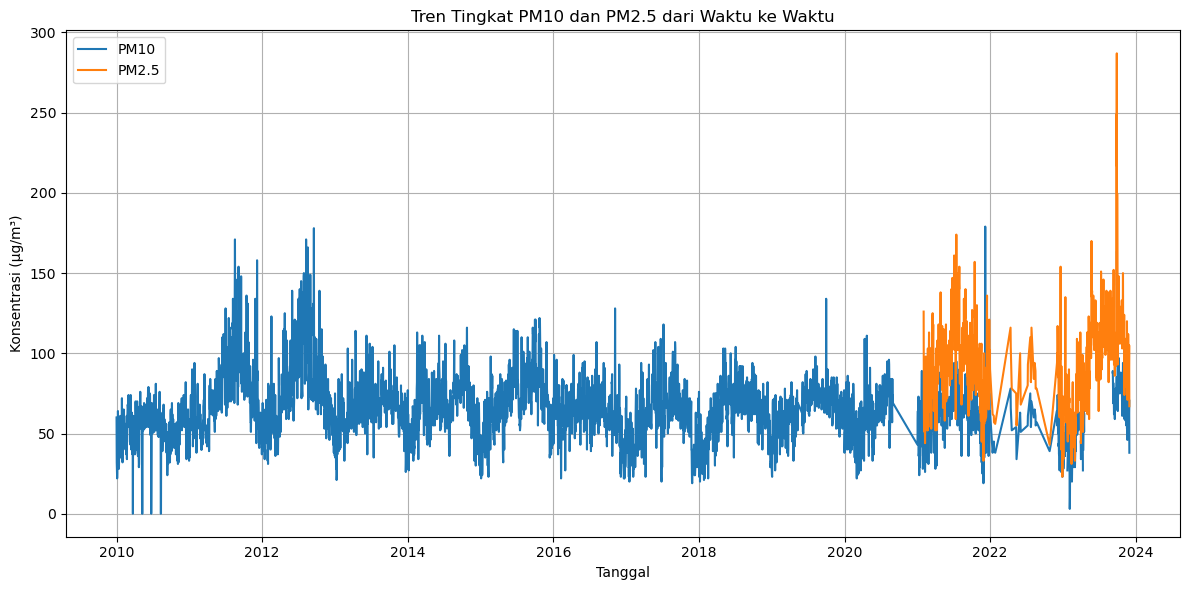

In [17]:
df_sorted = data_viz.sort_values(by='date')

plt.figure(figsize=(12, 6))
plt.plot(df_sorted['date'], df_sorted['pm10'], label='PM10')
plt.plot(df_sorted['date'], df_sorted['pm25'], label='PM2.5')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi (µg/m³)')
plt.title('Tren Tingkat PM10 dan PM2.5 dari Waktu ke Waktu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Insight :**

* Grafik ini menunjukkan tren konsentrasi PM10 dan PM2.5 dari tahun 2010 hingga sekitar akhir 2023.

* Terlihat adanya `pola musiman` dalam tingkat kedua polutan, dengan kecenderungan peningkatan pada periode waktu tertentu setiap tahunnya.

* Secara umum, tingkat `PM10 cendeerung lebih tinggi` dibandingkan PM2.5.

* Terdapat `lonjakan signifikan` pada tingkat PM2.5 menjelang akhir periode pengamatan (sekitar tahun 2023-2024).

* Data terlihat lebih jarang atau terputus-putus pada beberapa periode waktu, terutama setelah tahun 2020.

### **V.II. Box Plot Distribusi Polutan per Stasiun**

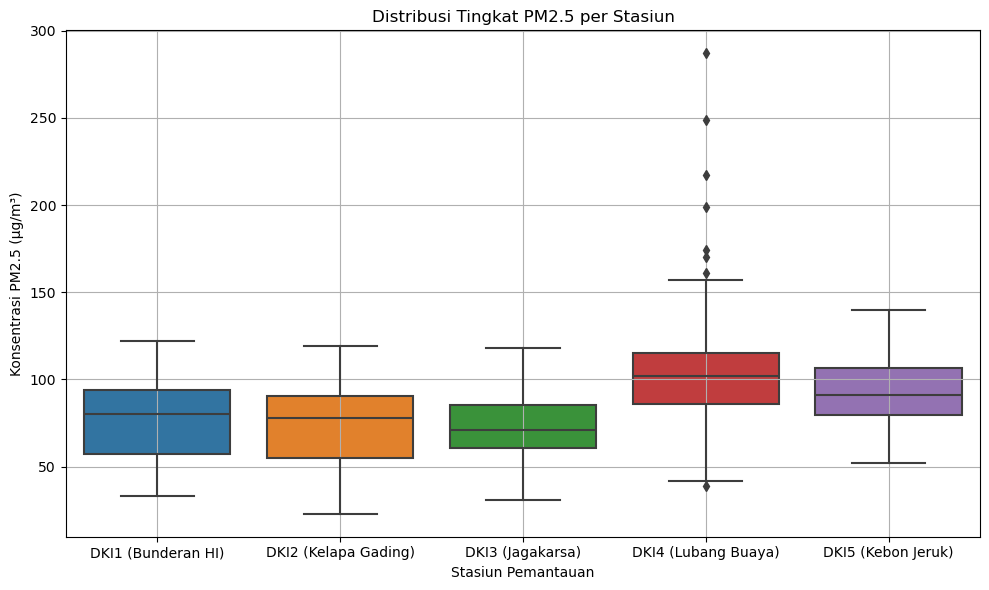

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='station', y='pm25', data=data_viz)
plt.title('Distribusi Tingkat PM2.5 per Stasiun')
plt.xlabel('Stasiun Pemantauan')
plt.ylabel('Konsentrasi PM2.5 (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

**Insight :**

* Grafik ini membandingkan distribusi konsentrasi PM2.5 di lima stasiun pemantaun berbeda.

* `DKI4 (Lubang Buaya)` menunjukkan `tingkat median PM2.5 yang paling tinggi` dibandingkan stasiun lainnya. Selain itu, stasiun ini juga memiliki `sebaran data yang paling luas` dan beberapa nilai _outlier_ yang tinggi.

* `DKI3 (Jagakarsa)` cenderung memiliki `tingkat median PM2.5 yang paling rendah` di antara kelima stasiun.

* Distribusi PM2.5 terlihat berbeda-beda antar stasiun, mengindikasikan variasi kualitas udara di berbagai lokasi pemantauan.

### **V.III. Bar Chart Kategori Kualitas Udara**

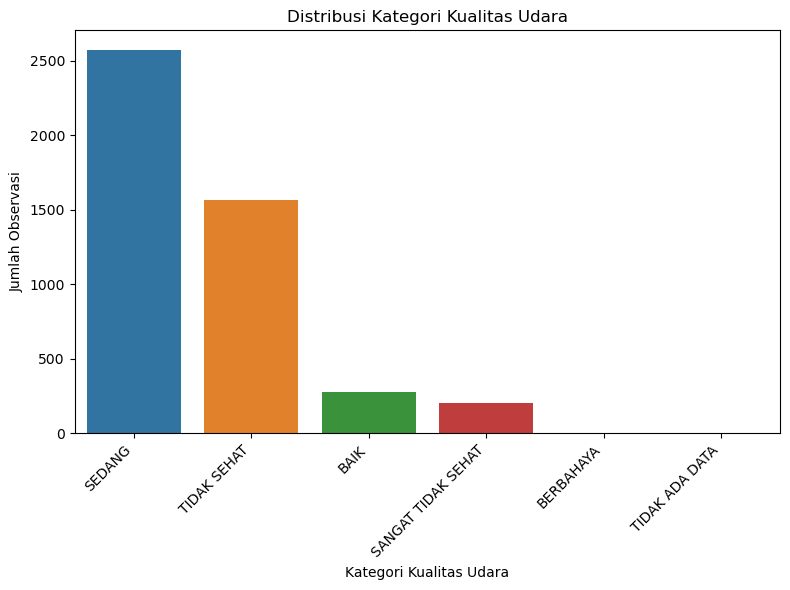

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='category', data=data_viz, order=data_viz['category'].value_counts().index)
plt.title('Distribusi Kategori Kualitas Udara')
plt.xlabel('Kategori Kualitas Udara')
plt.ylabel('Jumlah Observasi')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Insight :**

* Grafik batang ini menunjukkan jumlah observasi untuk setiap kategori kualitas udara dalam dataset.

* Kategori "SEDANG" adalah kategori yang paling sering terjadi, diikuti oleh "TIDAK SEHAT".

* Kategori "BAIK" dan "SANGAT TIDAK SEHAT" memiliki jumlah observasi yang jauh lebih sedikit.

### **V.IV. Scatter Plot Korelasi Antar Polutan (PM10 vs PM2.5)**

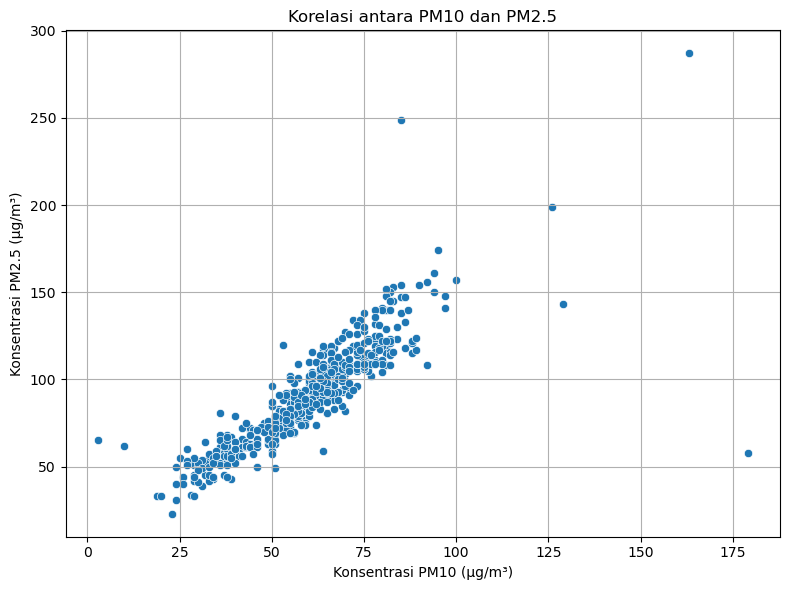

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pm10', y='pm25', data=data_viz)
plt.title('Korelasi antara PM10 dan PM2.5')
plt.xlabel('Konsentrasi PM10 (µg/m³)')
plt.ylabel('Konsentrasi PM2.5 (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

**Insight :**

* Scatter plot ini menggambarkan hubungan antara konsentrasi PM10 dan PM2.5.

* Terlihat adanya `korelasi positif yang kuat` antara PM10 dan PM2.5, ketika tingkat PM10 meningkat, tingkat PM2.5 juga cenderung meningkat.

* Sebagian besar titik data terkumpul dalam pola linear yang jelas, mengindikasikan hubungan yang konsisten.

* Terdapat beberapa _outlier_ dengan tingkat PM10 atau PM2.5.

* Korelasi yang kuat ini mendukung ide untuk memprediksi PM2.5 berdasarkan PM10 menggunakan model regresi linear.

### **V.V. Stacked Bar Chart Polutan Tertinggi (Critical) per Tahun (atau Bulan)**

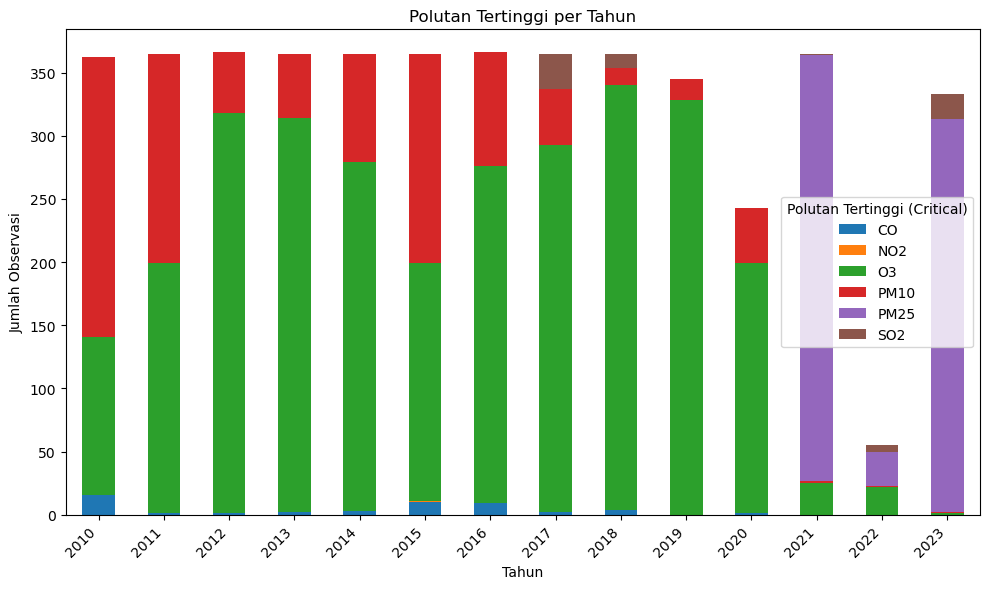

In [21]:
data_viz['year'] = data_viz['date'].dt.year

critical_per_year = data_viz.groupby('year')['critical'].value_counts().unstack(fill_value=0)

critical_per_year.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Polutan Tertinggi per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Observasi')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Polutan Tertinggi (Critical)')
plt.tight_layout()
plt.show()

**Insight :**

* Grafik batang bertumpuk ini menunjukkan polutan mana yang tercatat sebagai "critical" (memiliki nilai maksimum di antara polutan lain pada hari tersebut) setiap tahunnya.

* `O3 (Ozon)` dan `PM10` tampak menjadi polutan yang paling sering menjadi "critical" pada sebagian besar tahun pengamatan awal.

* Setelah tahun 2020, `PM2.5` muncul sebagai polutan yang dominan menjadi "critical".

* Kontribusi polutan lain seperti CO, NO2, dan SO2 relatif kecil dalam menentukan kategori kualitas udara "critical" berdasarkan data ini.

* Perubahan pola polutan "critical" dari waktu ke waktu mungkin mengindikasikan perubahan sumber polusi atau kondisi atmosfer.

## **VI. Feature Engineering**

In [22]:
df1 = df.copy()

### **VI.I. Check Duplicate Data & Handling Missing Value**

In [23]:
print("Jumlah Data Duplikat: ", df1.duplicated().sum())
print(" ")
print("Jumlah Missing Value: "), df1.isnull().sum()

Jumlah Data Duplikat:  0
 
Jumlah Missing Value: 


(None,
 date           0
 station        0
 pm10         160
 pm25        3903
 so2           19
 co             8
 o3             5
 no2            8
 max            0
 critical       1
 category       0
 dtype: int64)

c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


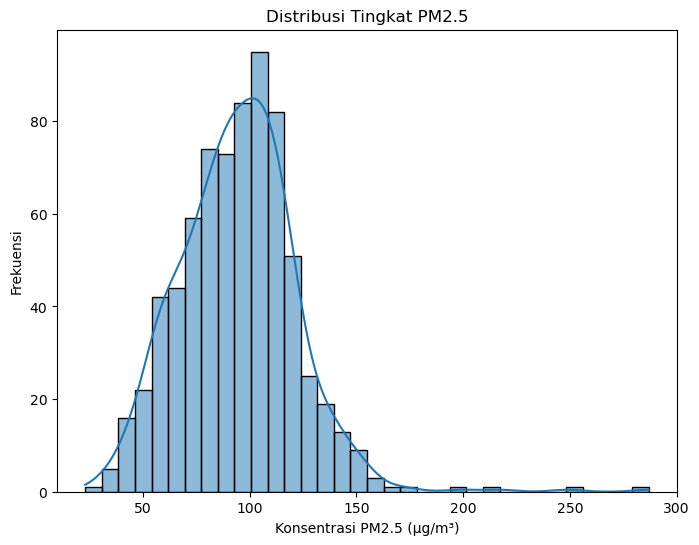

In [24]:
plt.figure(figsize=(8, 6))
sns.histplot(df1['pm25'], kde=True) 
plt.title('Distribusi Tingkat PM2.5')
plt.xlabel('Konsentrasi PM2.5 (µg/m³)')
plt.ylabel('Frekuensi')
plt.show()

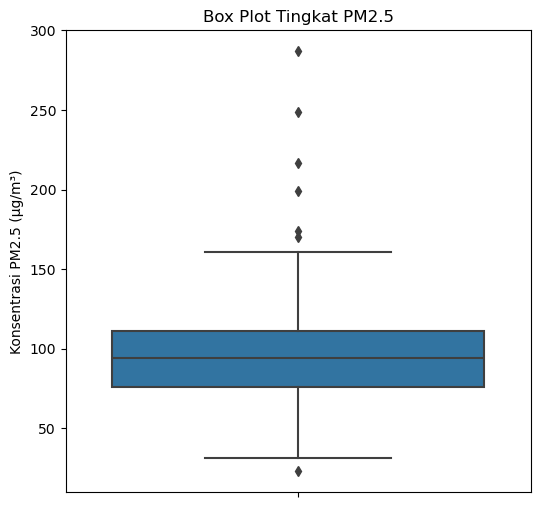

In [25]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df1['pm25'])
plt.title('Box Plot Tingkat PM2.5')
plt.ylabel('Konsentrasi PM2.5 (µg/m³)')
plt.show()

In [26]:
df1['pm25'] = df1['pm25'].fillna(df1['pm25'].median())

df1['pm10'] = df1['pm10'].fillna(df1['pm10'].median())

df1 = df1.dropna(subset=['so2', 'co', 'o3', 'no2', 'critical'])

### **VI.II. Split Features, Target, Train-Test**

In [27]:
X = df1.drop(columns=['pm25']) 
y = df1['pm25']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3676, 10)
X_test shape: (920, 10)
y_train shape: (3676,)
y_test shape: (920,)


### **VI.III. Handling Outlier**

In [28]:
def find_boundaries(dataframe):

    result = pd.DataFrame()
    columns_name = []
    skew = []
    upper = []
    lower = []
    outlier_tf = []
    type = []

    num_columns = dataframe.select_dtypes(include=['int64','float64'])
    

    for column in num_columns:
        columns_name.append(column)

        skewness = dataframe[column].skew()
        skew.append(skewness)

        if -0.5 <= skewness <= 0.5:
            upper_boundary = dataframe[column].mean() + (3 * dataframe[column].std())
            lower_boundary = dataframe[column].mean() - (3 * dataframe[column].std())
            type.append("normal")
    
        elif -1 <= skewness <= -0.5 or 0.5 <= skewness <= 1:
            IQR = dataframe[column].quantile(0.75) - dataframe[column].quantile(0.25)
            lower_boundary = dataframe[column].quantile(0.25) - (IQR * 1.5)
            upper_boundary = dataframe[column].quantile(0.75) + (IQR * 1.5)
            type.append("moderate")

        elif -1 >= skewness or skewness >= 1:
            IQR = dataframe[column].quantile(0.75) - dataframe[column].quantile(0.25)
            lower_boundary = dataframe[column].quantile(0.25) - (IQR * 3)
            upper_boundary = dataframe[column].quantile(0.75) + (IQR * 3)
            type.append("extreme")

        upper.append(upper_boundary)
        lower.append(lower_boundary)

        outliers = (dataframe[column] < lower_boundary) | (dataframe[column] > upper_boundary)
        outlier_tf.append(any(outliers))

    result['columns'] = columns_name
    result['skewness'] = skew
    result['upper_value'] = upper
    result['lower_value'] = lower
    result['outliers'] = outlier_tf
    result['skew_type'] = type

    return result

In [29]:
num_columns = X_train.select_dtypes(include=['int64','float64'])

In [30]:
dfbound = find_boundaries(num_columns)
dfbound

,columns,skewness,upper_value,lower_value,outliers,skew_type
0,pm10,0.728631,105.0,25.00,True,moderate
1,so2,0.828357,58.0,-6.00,True,moderate
2,co,1.102068,85.0,-27.00,True,extreme
3,o3,1.096912,284.0,-123.75,True,extreme
4,no2,3.194871,45.0,-11.00,True,extreme
5,max,1.368179,262.0,-74.00,True,extreme


#### **VI.III.I Capping**

In [31]:
outlier_column = dfbound[(dfbound['outliers']==True)&(dfbound['skew_type']=='moderate')]['columns'].tolist()
outlier_column

['pm10', 'so2']

In [32]:
winsoriser_skew = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=1.5,
                            variables=outlier_column)

X_train_capped = winsoriser_skew.fit_transform(X_train)
X_test_capped = winsoriser_skew.transform(X_test)

In [33]:
outlier_column_skew = dfbound[(dfbound['outliers']==True)&(dfbound['skew_type']=='extreme')]['columns'].tolist()
outlier_column_skew

['co', 'o3', 'no2', 'max']

In [34]:
winsoriser_skew_extreme = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=2.5,
                            variables=outlier_column_skew)

X_train_capped = winsoriser_skew_extreme.fit_transform(X_train)
X_test_capped = winsoriser_skew_extreme.transform(X_test)

In [35]:
def diagnostic_plots(df1, variable):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df1[variable], bins=30)
    plt.title('Histogram')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df1[variable])
    plt.title('Boxplot')

    plt.show()

pm10 - Before Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


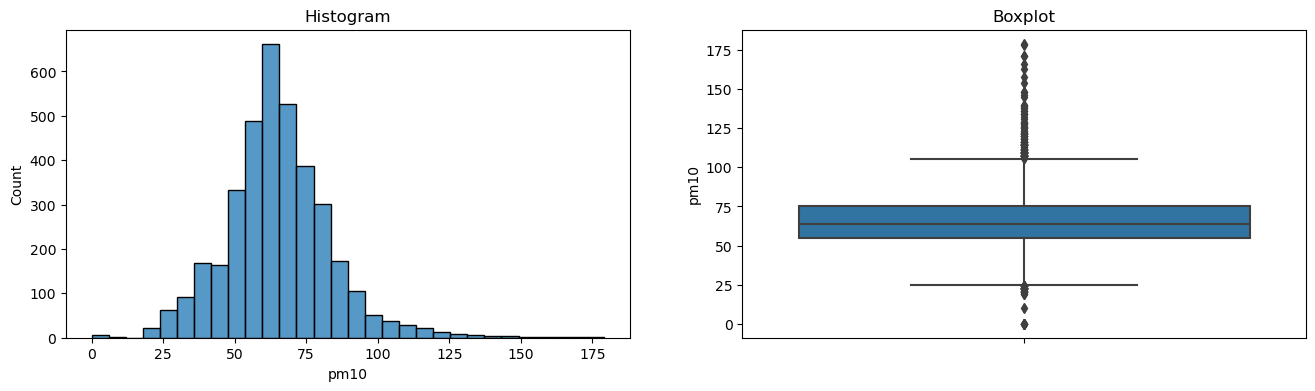


pm10 - After Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


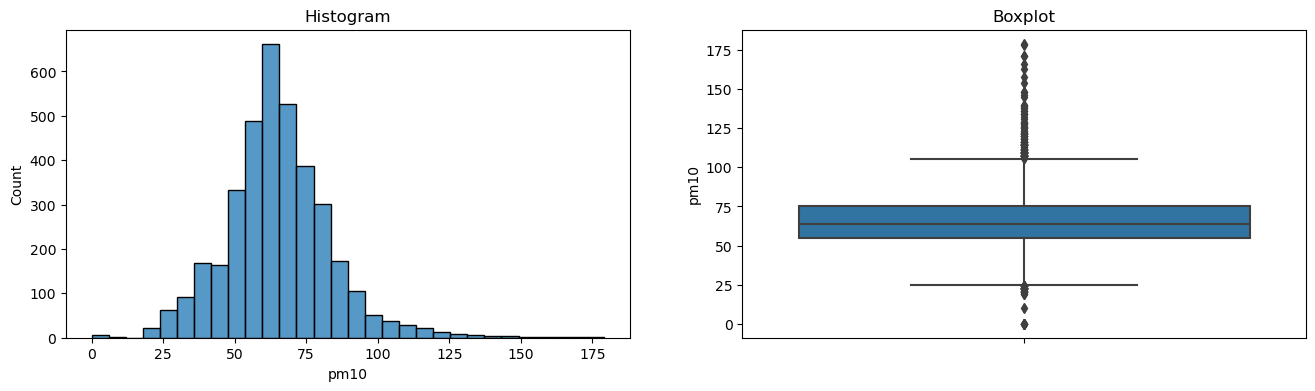

so2 - Before Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


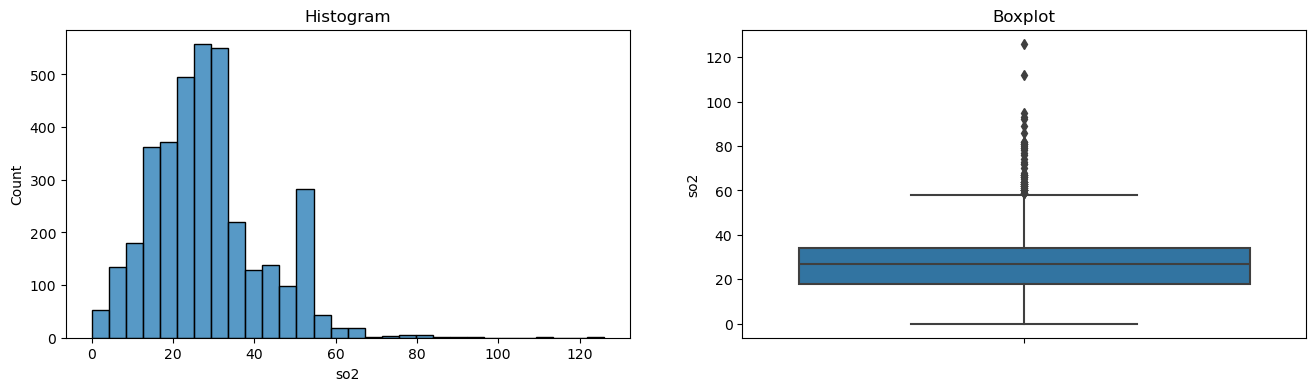


so2 - After Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


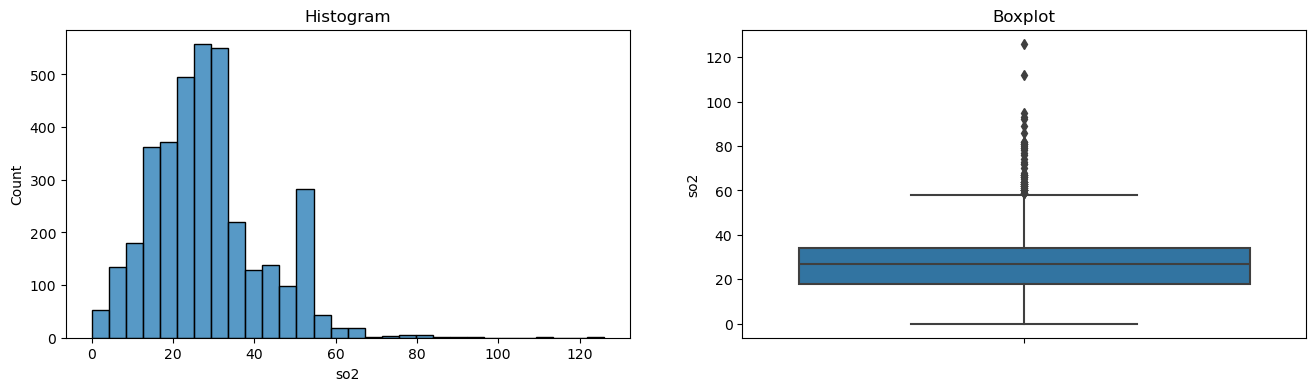

co - Before Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


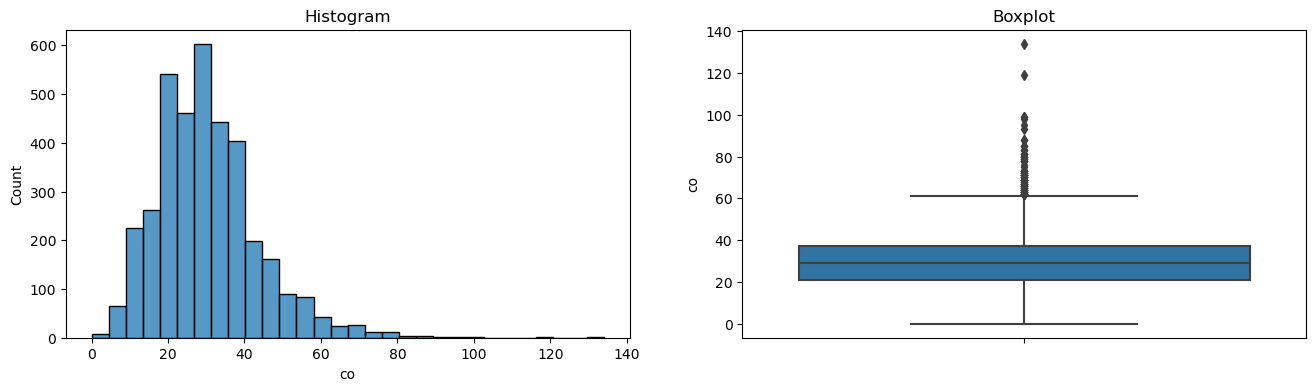


co - After Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


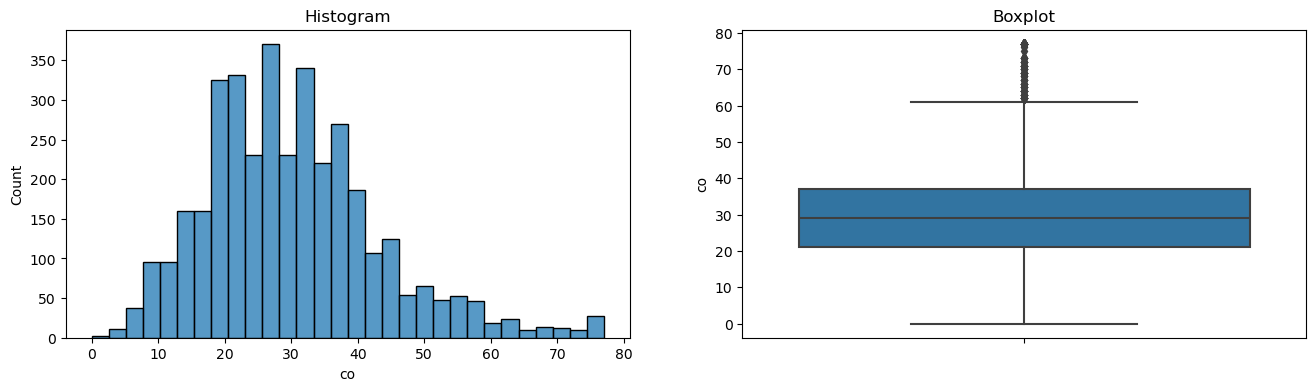

o3 - Before Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


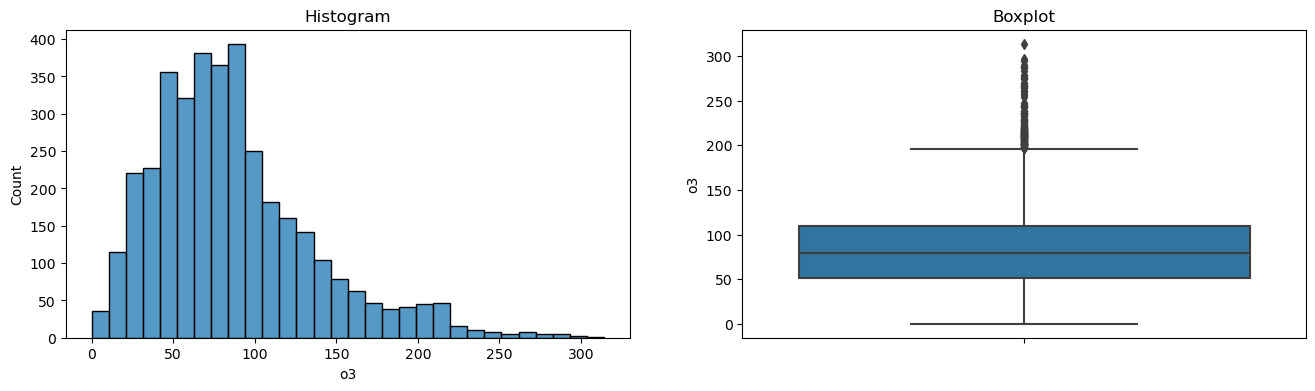


o3 - After Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


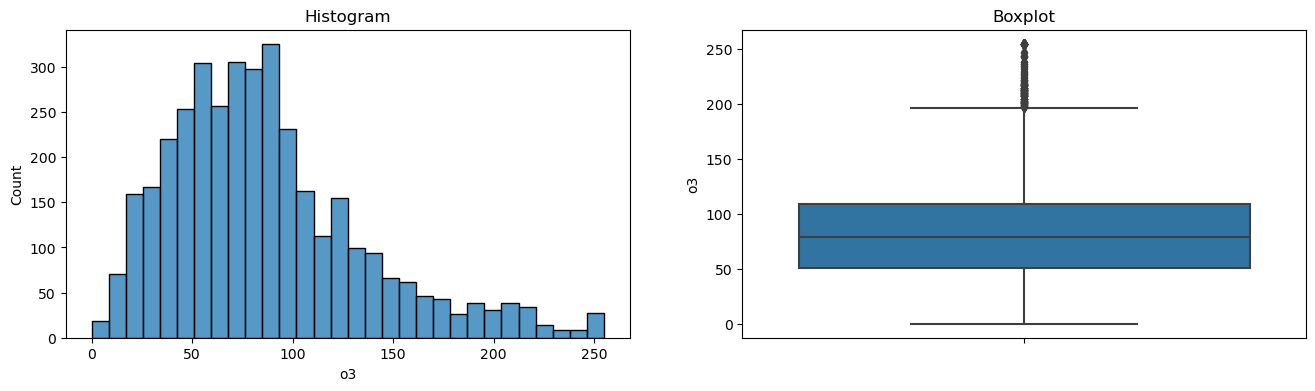

no2 - Before Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


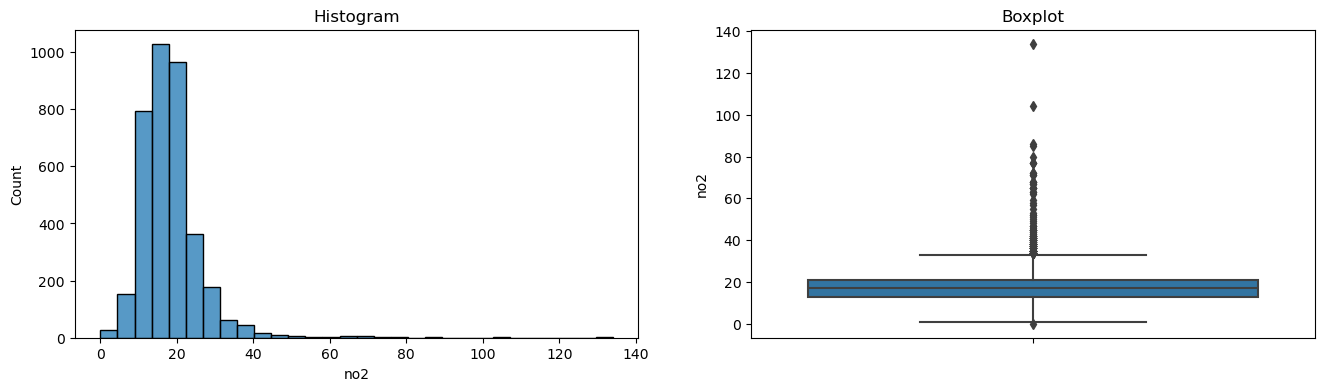


no2 - After Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


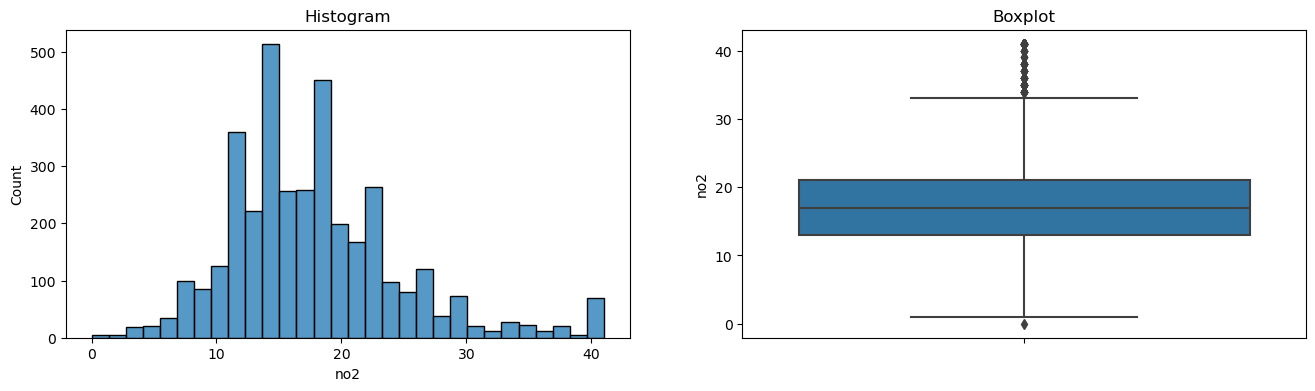

max - Before Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


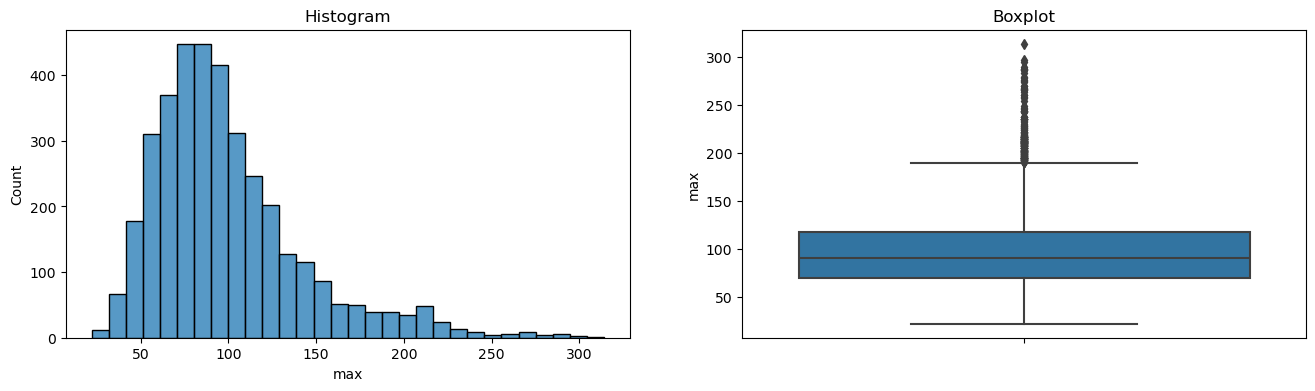


max - After Capping


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


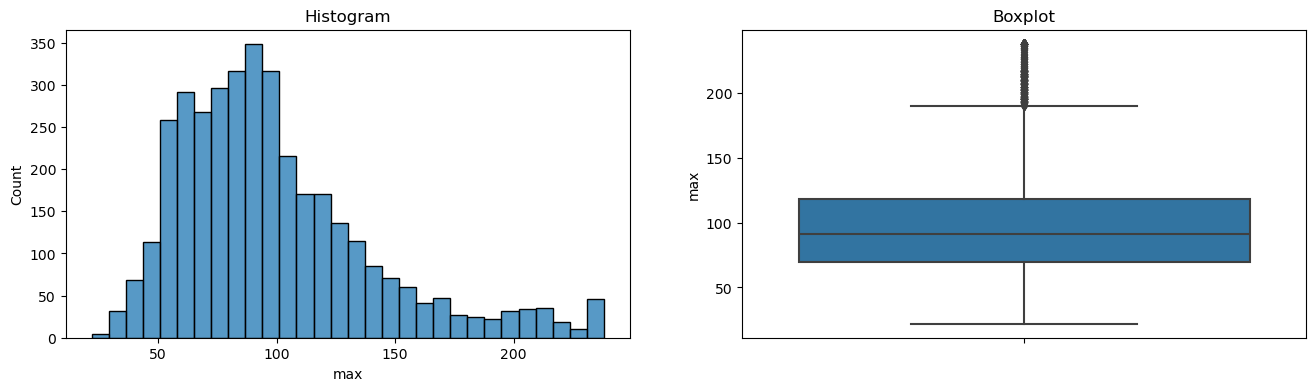

In [36]:
for col in outlier_column+outlier_column_skew:
    print(f'{col} - Before Capping')
    diagnostic_plots(X_train, col)

    print(f'\n{col} - After Capping')
    diagnostic_plots(X_train_capped, col)

### **VI.IV. Check Cardinality**

In [37]:
pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_rows', None)

listItem = []
for col in df1.columns :
    listItem.append( [col, df1[col].nunique(), df1[col].unique()])

unique_val_df = pd.DataFrame(columns=['Nama Kolom', 'Jumlah Unique', 'Unique'],
                     data=listItem)

unique_val_df

,Nama Kolom,Jumlah Unique,Unique
0,date,4596,"[2010-01-01 00:00:00, 2010-01-02 00:00:00, 2010-01-03 00:00:00, 2010-01-04 00:00:00, 2010-01-05 00:00:00, 2010-01-06 00:00:00, 2010-01-07 00:00:00, 2010-01-08 00:00:00, 2010-01-09 00:00:00, 2010-01-10 00:00:00, 2010-01-11 00:00:00, 2010-01-12 00:00:00, 2010-01-13 00:00:00, 2010-01-14 00:00:00, 2010-01-15 00:00:00, 2010-01-16 00:00:00, 2010-01-17 00:00:00, 2010-01-18 00:00:00, 2010-01-19 00:00:00, 2010-01-20 00:00:00, 2010-01-21 00:00:00, 2010-01-22 00:00:00, 2010-01-23 00:00:00, 2010-01-24 00:00:00, 2010-01-25 00:00:00, 2010-01-26 00:00:00, 2010-01-27 00:00:00, 2010-01-28 00:00:00, 2010-01-29 00:00:00, 2010-01-30 00:00:00, 2010-01-31 00:00:00, 2010-02-01 00:00:00, 2010-02-02 00:00:00, 2010-02-03 00:00:00, 2010-02-04 00:00:00, 2010-02-05 00:00:00, 2010-02-06 00:00:00, 2010-02-07 00:00:00, 2010-02-08 00:00:00, 2010-02-09 00:00:00, 2010-02-10 00:00:00, 2010-02-11 00:00:00, 2010-02-12 00:00:00, 2010-02-13 00:00:00, 2010-02-14 00:00:00, 2010-02-15 00:00:00, 2010-02-16 00:00:00, 2010-02-17 00:00:00, 2010-02-18 00:00:00, 2010-02-19 00:00:00, 2010-02-20 00:00:00, 2010-02-21 00:00:00, 2010-02-22 00:00:00, 2010-02-23 00:00:00, 2010-02-24 00:00:00, 2010-02-25 00:00:00, 2010-02-26 00:00:00, 2010-02-27 00:00:00, 2010-02-28 00:00:00, 2010-03-01 00:00:00, 2010-03-02 00:00:00, 2010-03-03 00:00:00, 2010-03-04 00:00:00, 2010-03-05 00:00:00, 2010-03-06 00:00:00, 2010-03-07 00:00:00, 2010-03-08 00:00:00, 2010-03-09 00:00:00, 2010-03-10 00:00:00, 2010-03-11 00:00:00, 2010-03-12 00:00:00, 2010-03-13 00:00:00, 2010-03-14 00:00:00, 2010-03-15 00:00:00, 2010-03-16 00:00:00, 2010-03-17 00:00:00, 2010-03-18 00:00:00, 2010-03-19 00:00:00, 2010-03-20 00:00:00, 2010-03-21 00:00:00, 2010-03-22 00:00:00, 2010-03-23 00:00:00, 2010-03-24 00:00:00, 2010-03-25 00:00:00, 2010-03-26 00:00:00, 2010-03-27 00:00:00, 2010-03-28 00:00:00, 2010-03-29 00:00:00, 2010-03-30 00:00:00, 2010-03-31 00:00:00, 2010-04-01 00:00:00, 2010-04-02 00:00:00, 2010-04-03 00:00:00, 2010-04-04 00:00:00, 2010-04-05 00:00:00, 2010-04-06 00:00:00, 2010-04-07 00:00:00, 2010-04-08 00:00:00, 2010-04-09 00:00:00, 2010-04-10 00:00:00, ...]"
1,station,5,"[DKI1 (Bunderan HI), DKI2 (Kelapa Gading), DKI3 (Jagakarsa), DKI4 (Lubang Buaya), DKI5 (Kebon Jeruk)]"
2,pm10,131,"[60.0, 32.0, 27.0, 22.0, 25.0, 30.0, 41.0, 64.0, 55.0, 34.0, 45.0, 28.0, 38.0, 35.0, 54.0, 44.0, 40.0, 61.0, 36.0, 51.0, 56.0, 59.0, 43.0, 72.0, 47.0, 50.0, 49.0, 63.0, 65.0, 46.0, 52.0, 37.0, 57.0, 68.0, 67.0, 74.0, 62.0, 58.0, 0.0, 48.0, 39.0, 70.0, 66.0, 29.0, 31.0, 76.0, 53.0, 69.0, 77.0, 79.0, 75.0, 81.0, 24.0, 33.0, 82.0, 42.0, 71.0, 90.0, 80.0, 94.0, 73.0, 78.0, 87.0, 84.0, 89.0, 86.0, 97.0, 92.0, 91.0, 93.0, 88.0, 104.0, 110.0, 105.0, 85.0, 108.0, 109.0, 112.0, 107.0, 103.0, 128.0, 83.0, 102.0, 101.0, 122.0, 116.0, 100.0, 96.0, 95.0, 119.0, 115.0, 134.0, 118.0, 127.0, 136.0, 171.0, 138.0, 113.0, 146.0, 126.0, ...]"
3,pm25,123,"[94.0, 60.0, 126.0, 70.0, 53.0, 59.0, 51.0, 55.0, 44.0, 57.0, 64.0, 98.0, 89.0, 73.0, 66.0, 63.0, 71.0, 52.0, 103.0, 90.0, 61.0, 54.0, 75.0, 113.0, 97.0, 81.0, 83.0, 95.0, 91.0, 99.0, 72.0, 92.0, 101.0, 123.0, 125.0, 96.0, 106.0, 118.0, 93.0, 77.0, 68.0, 78.0, 76.0, 69.0, 67.0, 85.0, 108.0, 82.0, 88.0, 105.0, 112.0, 115.0, 116.0, 117.0, 138.0, 102.0, 87.0, 58.0, 109.0, 79.0, 100.0, 86.0, 80.0, 114.0, 140.0, 84.0, 107.0, 119.0, 147.0, 134.0, 128.0, 141.0, 161.0, 153.0, 130.0, 145.0, 156.0, 132.0, 174.0, 150.0, 110.0, 104.0, 148.0, 131.0, 154.0, 122.0, 111.0, 120.0, 127.0, 157.0, 74.0, 45.0, 56.0, 33.0, 65.0, 124.0, 136.0, 121.0, 62.0, 43.0, ...]"
4,so2,87,"[4.0, 2.0, 3.0, 8.0, 5.0, 10.0, 6.0, 7.0, 9.0, 12.0, 11.0, 18.0, 0.0, 14.0, 15.0, 19.0, 17.0, 16.0, 13.0, 21.0, 20.0, 23.0, 22.0, 25.0, 27.0, 26.0, 31.0, 24.0, 28.0, 30.0, 33.0, 32.0, 34.0, 45.0, 44.0, 52.0, 29.0, 41.0, 53.0, 51.0, 56.0, 38.0, 36.0, 40.0, 35.0, 37.0, 54.0, 39.0, 48.0, 42.0, 50.0, 55.0, 47.0, 43.0, 49.0, 46.0, 72.0, 70.0, 58.0, 60.0, 86.0, 93.0, 67.0, 89.0, 81.0, 68.0, 77.0, 78.0, 82.0, 92.0, 

### **VI.V. Feature Selection**

In [38]:
nominals = ['station', 'critical', 'category']
num_col = ['date', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max']

#### **VI.V.I. Nominal Selection**

In [39]:
alpha = 0.05

correlation_df_nominal = pd.DataFrame(columns=['categorical_column', 'f-statistic', 'p-value', 'is_correlated'])

for cat_column in nominals:
  
    if not pd.api.types.is_numeric_dtype(y_train):
        print(f"Skipping column {cat_column}: target variable (y_train) is not numeric.")
        continue  

    groups = []
    for category in X_train[cat_column].unique():
        groups.append(y_train[X_train[cat_column] == category])

    f_statistic, p_value = f_oneway(*groups)  

    is_correlated = 'Yes' if p_value < alpha else 'No'

    correlation_df_nominal = pd.concat([
        correlation_df_nominal,
        pd.DataFrame({'categorical_column': [cat_column], 'f-statistic': [f_statistic], 'p-value': [p_value], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

print(correlation_df_nominal)

  categorical_column  f-statistic       p-value is_correlated
0            station    24.839956  2.538514e-20           Yes
1           critical    46.838957  1.884617e-38           Yes
2           category    91.006550  7.118711e-74           Yes


C:\Users\Lenovo ThinkPad X280\AppData\Local\Temp\ipykernel_2972\4225489014.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df_nominal = pd.concat([


#### **VI.V.II. Numerical Selection**

In [40]:
alpha = 0.05  
num_col = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

correlation_df_num = pd.DataFrame(columns=['numerical_column', 'correlation-statistic', 'p-value', 'is_correlated'])

for cont_column in num_col:
    if X_train[cont_column].nunique() < 2:
        corr, p = np.nan, np.nan
        is_correlated = 'No'
    else:
        corr, p = spearmanr(X_train[cont_column], y_train)
        is_correlated = 'Yes' if p < alpha else 'No'
    
    correlation_df_num = pd.concat([
        correlation_df_num,
        pd.DataFrame({'numerical_column': [cont_column], 'correlation-statistic': [corr], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

correlation_df_num

C:\Users\Lenovo ThinkPad X280\AppData\Local\Temp\ipykernel_2972\1227988600.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df_num = pd.concat([


,numerical_column,correlation-statistic,p-value,is_correlated
0,pm10,0.232238,3.300361e-46,Yes
1,so2,-0.026880,1.032182e-01,No
2,co,0.070927,1.675340e-05,Yes
3,o3,-0.009113,5.806929e-01,No
4,no2,0.102101,5.487864e-10,Yes
5,max,0.273165,6.491411e-64,Yes


### **VI.VI. Feature Encoding & Scaling**

In [47]:
nominals = ['station', 'critical', 'category']
num_col = ['pm10', 'co', 'no2', 'max']

In [48]:
# Preprocessing pipeline
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

nominals_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', nominals_pipeline, nominals)
])

# === Pipeline Model === #
# 1. Linear Regression
pipe_linreg = Pipeline([
    ('preprocess', preprocessor),
    ('linreg', LinearRegression())
])

# 2. Ridge Regression
pipe_ridge = Pipeline([
    ('preprocess', preprocessor),
    ('ridge', Ridge(alpha=1.0))
])

# 3. Lasso Regression
pipe_lasso = Pipeline([
    ('preprocess', preprocessor),
    ('lasso', Lasso(alpha=0.1))
])

# 4. Decision Tree Regressor
pipe_dt = Pipeline([
    ('preprocess', preprocessor),
    ('dt', DecisionTreeRegressor(random_state=42))
])

# 5. Random Forest Regressor
pipe_rf = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 6. Support Vector Regressor (SVR)
pipe_svr = Pipeline([
    ('preprocess', preprocessor),
    ('svr', SVR())
])

# 7. K-Nearest Neighbors Regressor
pipe_knn = Pipeline([
    ('preprocess', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# 8. Gradient Boosting Regressor
pipe_gbr = Pipeline([
    ('preprocess', preprocessor),
    ('gbr', GradientBoostingRegressor(random_state=42))
])

# === (Optional) Tambahkan PCA === #
pipe_rf_pca = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

display(pipe_linreg)
display(pipe_ridge)
display(pipe_lasso)
display(pipe_dt)
display(pipe_rf)
display(pipe_svr)
display(pipe_knn)
display(pipe_gbr)
display(pipe_rf_pca)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pm10', 'co', 'no2', 'max']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station', 'critical',
                                                   'category'])])),
                ('linreg', LinearRegression())])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pm10', 'co', 'no2', 'max']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station', 'critical',
                                                   'category'])])),
                ('ridge', Ridge())])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pm10', 'co', 'no2', 'max']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station', 'critical',
                                                   'category'])])),
                ('lasso', Lasso(alpha=0.1))])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pm10', 'co', 'no2', 'max']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station', 'critical',
                                                   'category'])])),
                ('dt', DecisionTreeRegressor(random_state=42))])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pm10', 'co', 'no2', 'max']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station', 'critical',
                                                   'category'])])),
                ('rf', RandomForestRegressor(random_state=42))])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pm10', 'co', 'no2', 'max']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station', 'critical',
                                                   'category'])])),
                ('svr', SVR())])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pm10', 'co', 'no2', 'max']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station', 'critical',
                                                   'category'])])),
                ('knn', KNeighborsRegressor())])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pm10', 'co', 'no2', 'max']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station', 'critical',
                                                   'category'])])),
                ('gbr', GradientBoostingRegressor(random_state=42))])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pm10', 'co', 'no2', 'max']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['station', 'critical',
                                                   'category'])])),
                ('pca', PCA(n_components=0.95)),
                ('rf', RandomForestRegressor(random_state=42))])

## **VII. Model Training**

In [49]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

pipelines = {
    'Linear Regression': pipe_linreg,
    'Ridge Regression' : pipe_ridge,
    'Lasso Regression' : pipe_lasso,
    'Decision Tree' : pipe_dt,
    'Random Forest' : pipe_rf,
    'Support Vector Regressor' : pipe_svr,
    'K-Nearest Neighbors' : pipe_knn,
    'Gradient Boosting' : pipe_gbr,
    'Random Forest + PCA' : pipe_rf_pca,
    'XGBoost': Pipeline([('preprocess', preprocessor), ('xgb', XGBRegressor(n_estimators=100, random_state=42))])
}

results = []
best_model_name = ""
best_r2 = -np.inf

for name, pipeline in pipelines.items():
    r2_scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
    
    mean_r2 = r2_scores.mean()
    mean_rmse = rmse_scores.mean()
    std_r2 = r2_scores.std()
    
    print(f"{name}")
    print("R² Scores (All Folds)   :", r2_scores)
    print("R² Mean                 :", mean_r2)
    print("R² Std                  :", std_r2)
    print("R²                      :", mean_r2 - std_r2, " - ", mean_r2 + std_r2)
    print("RMSE Mean               :", mean_rmse)
    print("-" * 50)
    
    results.append({
        'Model': name,
        'R² Mean': mean_r2,
        'R² Std': std_r2,
        'R² Range': f"{(mean_r2 - std_r2):.4f} - {(mean_r2 + std_r2):.4f}",
    })
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_model_name = name
        
results_df = pd.DataFrame(results).sort_values(by='R² Mean', ascending=False)
display(results_df)

print('Best model:', best_model_name)
print('Best Model R² Mean:', best_r2)



Linear Regression
R² Scores (All Folds)   : [0.16850802 0.13588271 0.14612926 0.14232696 0.12518121]
R² Mean                 : 0.14360562938631294
R² Std                  : 0.014333426443741047
R²                      : 0.12927220294257188  -  0.157939055830054
RMSE Mean               : 9.948803283125509
--------------------------------------------------
Ridge Regression
R² Scores (All Folds)   : [0.16799362 0.13717738 0.14649569 0.14221259 0.12563329]
R² Mean                 : 0.1439025150280014
R² Std                  : 0.013920876209039906
R²                      : 0.1299816388189615  -  0.15782339123704128
RMSE Mean               : 9.947405466054075
--------------------------------------------------
Lasso Regression
R² Scores (All Folds)   : [0.1420969  0.1516338  0.14638302 0.13195429 0.12758093]
R² Mean                 : 0.1399297872950617
R² Std                  : 0.00893786851720394
R²                      : 0.13099191877785776  -  0.14886765581226563
RMSE Mean               : 

,Model,R² Mean,R² Std,R² Range
4,Random Forest,0.917196,0.020044,0.8972 - 0.9372
9,XGBoost,0.906889,0.029294,0.8776 - 0.9362
7,Gradient Boosting,0.900813,0.015521,0.8853 - 0.9163
3,Decision Tree,0.871164,0.040860,0.8303 - 0.9120
6,K-Nearest Neighbors,0.733475,0.080231,0.6532 - 0.8137
8,Random Forest + PCA,0.679415,0.027173,0.6522 - 0.7066
5,Support Vector Regressor,0.498948,0.084885,0.4141 - 0.5838
1,Ridge Regression,0.143903,0.013921,0.1300 - 0.1578
0,Linear Regression,0.143606,0.014333,0.1293 - 0.1579
2,Lasso Regression,0.139930,0.008938,0.1310 - 0.1489


Best model: Random Forest
Best Model R² Mean: 0.9171959082948715


### **VII.I. Hyperparameter Tuning**

In [52]:
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

grid_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_grid_rf,
                             cv=5, n_iter=30, random_state=42,
                             n_jobs=1, scoring='r2', verbose=1)

grid_rf.fit(X_train, y_train)

print('Best cross-validation R² score: {:.4f}'.format(grid_rf.best_score_))
print('Best parameters: ', grid_rf.best_params_)
print('Test set R² score: {:.4f}'.format(grid_rf.score(X_test, y_test)))

best_estimator_rf = grid_rf.best_estimator_

print('R² - Train : ', best_estimator_rf.score(X_train, y_train))
print('R² - Test : ', best_estimator_rf.score(X_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\Lenovo ThinkPad X280\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

Best cross-validation R² score: 0.9323
Best parameters:  {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'auto', 'rf__max_depth': 20, 'rf__bootstrap': True}
Test set R² score: 0.9699
R² - Train :  0.9898746132510841
R² - Test :  0.969905094554676


## **VIII. Model Evaluation**

R² Score: 0.9688
RMSE    : 1.8291
MAE     : 0.3409


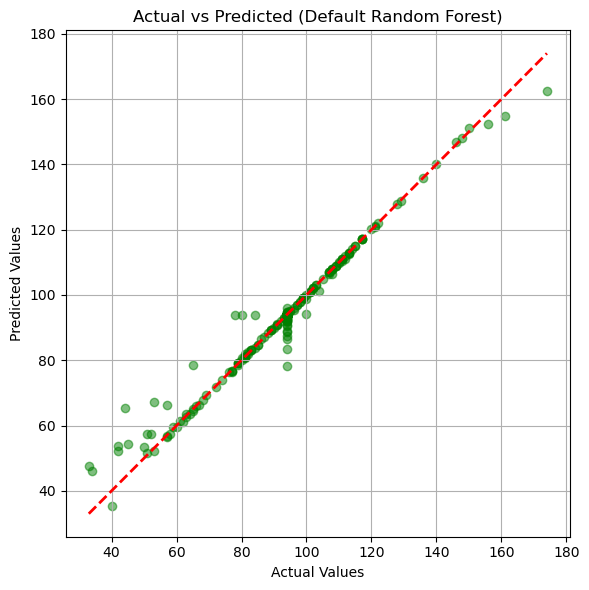

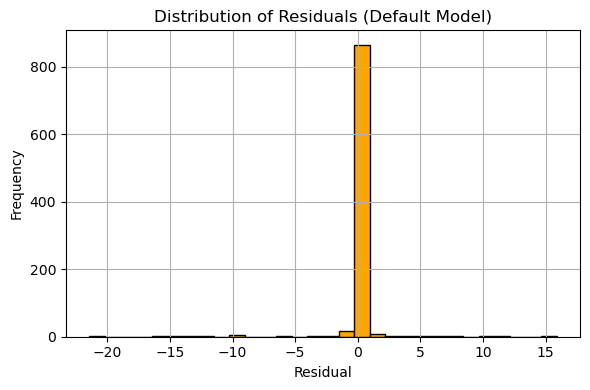

In [58]:
pipe_rf.fit(X_train, y_train)
y_pred_test_default = pipe_rf.predict(X_test)

print("R² Score: {:.4f}".format(r2_score(y_test, y_pred_test_default)))
print("RMSE    : {:.4f}".format(mean_squared_error(y_test, y_pred_test_default, squared=False)))
print("MAE     : {:.4f}".format(mean_absolute_error(y_test, y_pred_test_default)))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test_default, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Default Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_test - y_pred_test_default
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Residuals (Default Model)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

R² Score - Test Set (Tuned Model): 0.9699
MAE - Test Set (Tuned Model): 0.3404
RMSE - Test Set (Tuned Model): 1.7950


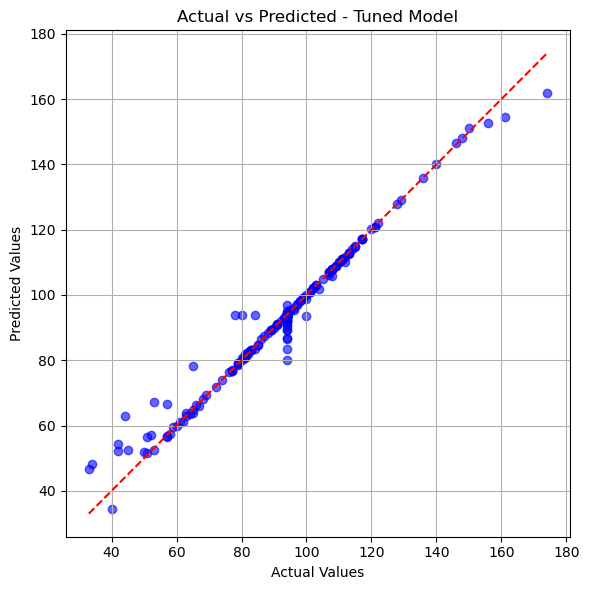

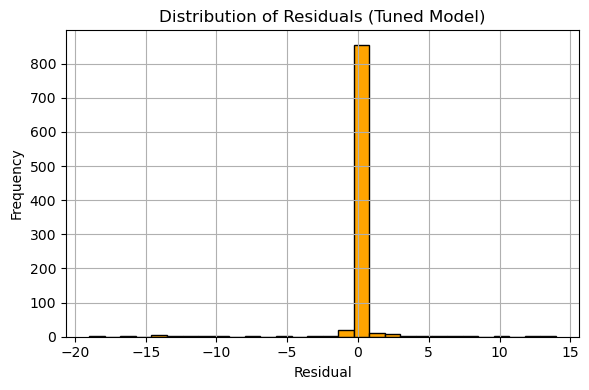

In [60]:
y_pred_test_tuned = best_estimator_rf.predict(X_test)

print('R² Score - Test Set (Tuned Model): {:.4f}'.format(r2_score(y_test, y_pred_test_tuned)))
print('MAE - Test Set (Tuned Model): {:.4f}'.format(mean_absolute_error(y_test, y_pred_test_tuned)))
print('RMSE - Test Set (Tuned Model): {:.4f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test_tuned))))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test_tuned, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted - Tuned Model")
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_test - y_pred_test_tuned
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Residuals (Tuned Model)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:
# === Evaluasi model default ===
y_pred_train_default = pipe_rf.predict(X_train)
y_pred_test_default = pipe_rf.predict(X_test)

print('R² - Train (Default Model): {:.4f}'.format(r2_score(y_train, y_pred_train_default)))
print('R² - Test  (Default Model): {:.4f}'.format(r2_score(y_test, y_pred_test_default)))

R² - Train (Default Model): 0.9902
R² - Test  (Default Model): 0.9688


In [62]:
# === Evaluasi model tuned ===
y_pred_train_tuned = best_estimator_rf.predict(X_train)
y_pred_test_tuned = best_estimator_rf.predict(X_test)

print('R² - Train (Tuned Model): {:.4f}'.format(r2_score(y_train, y_pred_train_tuned)))
print('R² - Test  (Tuned Model): {:.4f}'.format(r2_score(y_test, y_pred_test_tuned)))

R² - Train (Tuned Model): 0.9899
R² - Test  (Tuned Model): 0.9699


## **XI. Model Saving**

In [64]:
with open('best_model_rf.pkl', 'wb') as file:
    pickle.dump(best_estimator_rf, file)

print("Model terbaik telah disimpan sebagai 'best_model_rf.pkl'")

Model terbaik telah disimpan sebagai 'best_model_rf.pkl'
